## 1. Loading dataset & Importing libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings(action="ignore")

df = pd.read_csv('/content/housing.csv')

## 2. Overview

In [25]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [26]:
print(f'Shape: {df.shape}')
df.info()

Shape: (20640, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [27]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## 3. Checking & Handling missing values

In [28]:
df.replace(['null', '', 'NULL', 'NaN'], np.nan, inplace=True) # Replacing nulls with np.nan to make sure it counts right

print(df.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [29]:
df.dropna(inplace=True)
df = df.drop_duplicates()

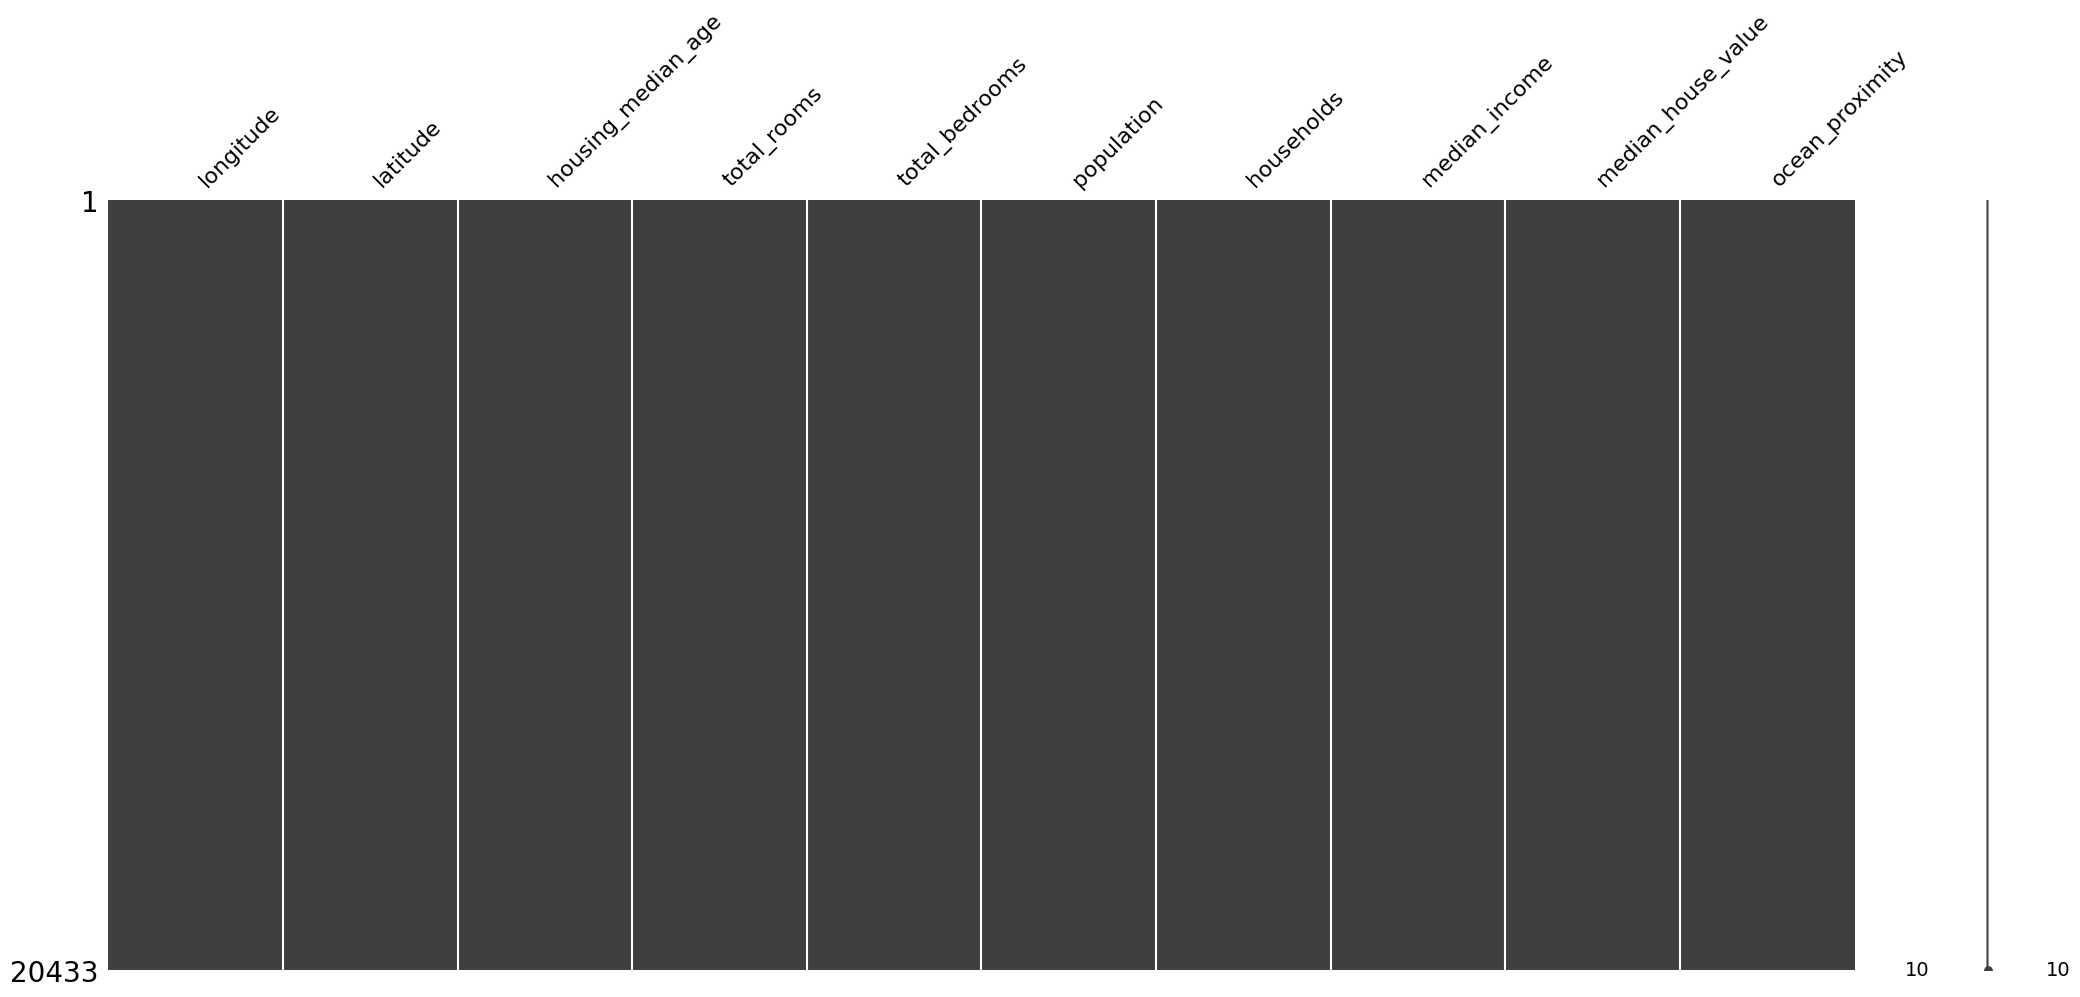

In [30]:
msno.matrix(df)
plt.show()

## 4. Encoding categorical feature

In [31]:
categorical_feature = ['ocean_proximity']
df = pd.get_dummies(df, columns=categorical_feature, drop_first=True)

## 5. Defining Features & Target

In [32]:
numeric_features = ['longitude', 'latitude', 'housing_median_age',
                    'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income']

features = [col for col in df.columns if col != 'median_house_value']

X = df[features].copy()
y = df['median_house_value'].copy()

## 6. Checking & Handling outliers

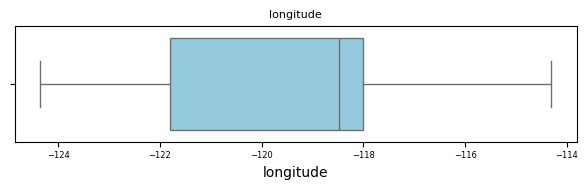

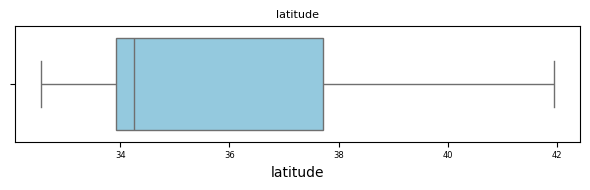

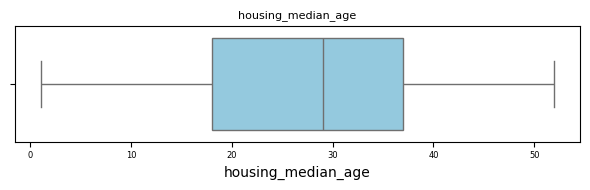

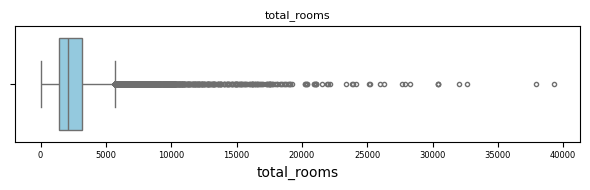

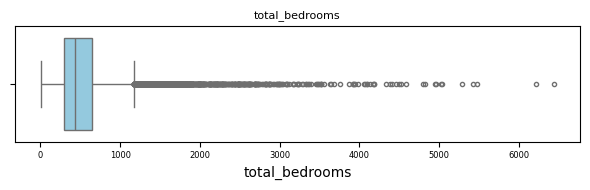

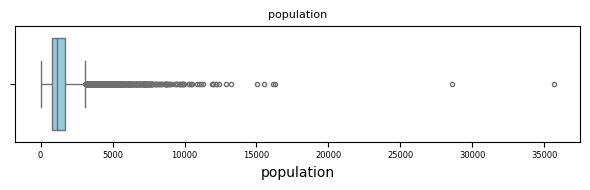

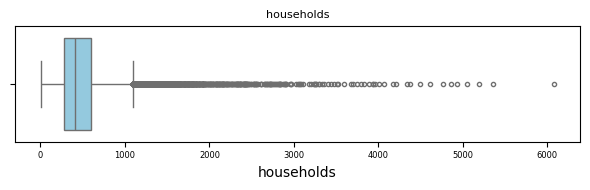

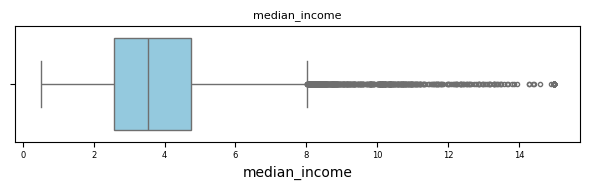

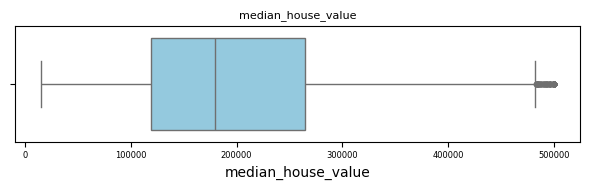

In [33]:
for col in numeric_features + ['median_house_value']:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col], color='skyblue', fliersize=3)
    plt.title(col, fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

In [34]:
z_scores = df[numeric_features + ['median_house_value']].apply(zscore)

outliers = (np.abs(z_scores) > 3)

outliers_summary = outliers.sum().to_dict()
print("Outliers summary (|Z| > 3):", outliers_summary)

Outliers summary (|Z| > 3): {'longitude': 0, 'latitude': 0, 'housing_median_age': 0, 'total_rooms': 371, 'total_bedrooms': 370, 'population': 339, 'households': 362, 'median_income': 340, 'median_house_value': 0}


## 7. Linear Regression

### 7.1 Train/Test Splitting & Preparing for Linear Regression

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

### 7.2 Handling Outliers for Linear Regression

In [36]:
# Log-transform skewed numeric features
skewed_features = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
X_train_lr[skewed_features] = X_train_lr[skewed_features].apply(lambda x: np.log1p(x))
X_test_lr[skewed_features] = X_test_lr[skewed_features].apply(lambda x: np.log1p(x))

# Cap extreme values at 1st and 99th percentile
for col in skewed_features:
    lower = X_train_lr[col].quantile(0.01)
    upper = X_train_lr[col].quantile(0.99)
    X_train_lr[col] = X_train_lr[col].clip(lower, upper)
    X_test_lr[col] = X_test_lr[col].clip(lower, upper)

### 7.3 Scaling Numeric Features for Linear Regression

In [37]:
scaler = StandardScaler()

X_train_lr_scaled = pd.DataFrame(scaler.fit_transform(X_train_lr), columns=X_train_lr.columns)
X_test_lr_scaled = pd.DataFrame(scaler.transform(X_test_lr), columns=X_test_lr.columns)

### 7.4. Training & Evaluating Linear Regression

In [38]:
lr_model = LinearRegression()
lr_model.fit(X_train_lr_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_lr_scaled)

# Metrics
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression -> RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}, R2: {r2_lr:.2f}")

Linear Regression -> RMSE: 70191.21, MAE: 52821.02, R2: 0.64


## 8. Random Forest

### 8.1 Training & Evaluating Random Forest

In [39]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)
y_pred_rf = rf_model.predict(X_test_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest -> RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R2: {r2_rf:.2f}")

Random Forest -> RMSE: 48767.99, MAE: 31677.92, R2: 0.83
